In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import nltk

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Input, Dense, Activation, Embedding, GlobalMaxPool1D, Flatten, MaxPooling1D 
from tensorflow.keras.layers import Conv1D, BatchNormalization, SpatialDropout1D, Bidirectional, LSTM, Dropout, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords

import sys
import datetime
import time

print("Python version: ", sys.version)
print("Version info.: ", sys.version_info)
print("TensorFlow version: ", tf.__version__)
print("TensorFlow.Keras version : ", tf.keras.__version__)

Python version:  3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 23:13:11) 
[GCC 7.3.0]
Version info.:  sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
TensorFlow version:  2.1.0
TensorFlow.Keras version :  2.2.4-tf


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.gpu_options.visible_device_list='0,1,2,3'

sess = tf.compat.v1.Session(config=config)
tf.debugging.set_log_device_placement(True)
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}\n'.format(strategy.num_replicas_in_sync))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:05:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: Tesla P100-PCIE-16GB, pci bus id: 0000:84:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla P100-PCIE-16GB, pci bus id: 0000:85:00.0, compute capability: 6.0
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device

INFO:tensorflow:Using MirroredStrategy with devices ('/job:l

In [3]:
path = '/data/user/mahoque/data_science_project/data/'
embedding_file=f'{path}glove.6B.50d.txt'
train_data_file = f'{path}emotion/train.csv'
test_data_file = f'{path}emotion/test.csv'
test_data_label_file=f'{path}test_labels.csv'

emotion_data_file=f'{path}emotion/text_emotion.csv'

tweet_data_file = f'{path}tweet_data.csv'

In [4]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [5]:
import preprocessor as p

stop_words = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])

train = pd.read_csv(train_data_file)
test = pd.read_csv(test_data_file)
test_label = pd.read_csv(test_data_label_file)

tweet_data = pd.read_csv(tweet_data_file)
tweet_data = pd.DataFrame(tweet_data)


display(tweet_data.shape)
display(train.shape)
display(test.shape)
#print(tweet_data.sample(2))
display(tweet_data.head(5))
display(train.head(5))
#print(p.clean(train["text"][2]))

list_sentences_train = train["text"].fillna("_na_").values
#list_classes = ["neutral", "sadness", "enthusiasm", "empty", "worry", "love", "fun"]
list_classes = ["negative", "neutral", "positive"]

y_tr = train["sentiment"]
y_tr = np.array(y_tr)
label_encoder = LabelEncoder()
y_tr = label_encoder.fit_transform(y_tr)
y = to_categorical(y_tr)
print(y[0])

test_labels = test["sentiment"]
test_labels = np.array(test_labels)
test_labels = label_encoder.fit_transform(test_labels)
test_labels = to_categorical(test_labels)
print(test_labels[0])
#print(sum())
display(test.head(5))
list_sentences_test = test["text"].fillna("_na_").values


crawled_tweet = tweet_data["tweet"]
crawled_tweet = crawled_tweet[:100000]



(650000, 4)

(27481, 4)

(3534, 3)

,Unnamed: 0,created_at,id,tweet
0,0,Thu Mar 12 21:12:58 +0000 2020,1238211405850923008,RT @Notorious4zzzz: Ain’t never gone stop fw C...
1,1,Thu Mar 12 21:12:58 +0000 2020,1238211405725270021,RT @KevinOConnorNBA: “The problem is that we a...
2,2,Thu Mar 12 21:12:58 +0000 2020,1238211405574070272,RT @sweatyhairy: dam yall really picked the wo...
3,3,Thu Mar 12 21:12:58 +0000 2020,1238211405297389571,RT @JheneAiko: #CHILOMBO deluxe coming soon 👀🌋...
4,4,Thu Mar 12 21:12:58 +0000 2020,1238211405284872193,RT @thepanda317: Mfs doing too much for likes ...


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


[0. 1. 0.]
[0. 1. 0.]


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [6]:
def processTweets(list_of_tweets):
    processedTweets=[]
    for tweet in list_of_tweets:
        processedTweets.append((clean_text(tweet)))
    return processedTweets

In [7]:
import string
from nltk.stem.snowball import SnowballStemmer 

def clean_text(text):
    
    text = str(text)
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    
    ## Clean the text
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text) # remove URLs
    text = re.sub('@[^\s]+', 'AT', text) # remove usernames
    text = re.sub(r'#([^\s]+)', r'\1', text) # remove the # in #hashtag
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
    ## Stemming
    #text = text.split()
    #stemmer = SnowballStemmer('english')
    #stemmed_words = [stemmer.stem(word) for word in text]
    #text = " ".join(stemmed_words)
    return text

In [8]:
list_sentences_train = processTweets(list_sentences_train)
list_sentences_test = processTweets(list_sentences_test)


In [9]:
crawled_tweets = processTweets(crawled_tweet)

In [10]:
print(list_sentences_train[0])

responded going


In [11]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train_1 = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test_1 = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train_1, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test_1, maxlen=maxlen)

In [12]:
print(list_tokenized_train_1[0])
print(X_t[0])

[9729, 8]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 9729    8]


In [13]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [14]:
print(len(embeddings_index))

400000


In [15]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/data/user/mahoque/.conda/envs/cs765/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.020940498, 0.6441043)

In [16]:
word_index = tokenizer.word_index
print(len(word_index))
nb_words = min(max_features, len(word_index))
print(nb_words)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
count = 0
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
    else:
        count = count+1
print(embedding_matrix.shape)
print(count)

23806
20000
(20000, 50)
4631


In [17]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

MAX_VOCAB = np.max([np.max(X_t), np.max(X_te)])
print(MAX_VOCAB)
print(max_features)
#max_features
with strategy.scope():
    input_tweet = Input(shape=(maxlen,), name='TweetInput')
    x = Embedding(MAX_VOCAB + 1, embed_size, weights=[embedding_matrix], name='embedding',
                     trainable=False)(input_tweet)
    x = SpatialDropout1D(0.1)(x)
    x = Conv1D(64, 3, activation='relu', padding='same', name='Conv1_1')(x)
    
    input_data = x
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    #x = MaxPooling1D(1, name='pool1')
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, 3, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    x = MaxPooling1D(2, name='pool2')(x)
    
    input_data = layers.Conv1D(128, 1, activation=None, padding='same')(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 3, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    x = MaxPooling1D(2, name='pool3')(x)
    
    input_data = layers.Conv1D(256, 1, activation=None, padding='same')(x)
    x = layers.Conv1D(256, 3, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(256, 3, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    x = MaxPooling1D(2, name='pool4')(x)
    
    input_data = layers.Conv1D(512, 1, activation=None, padding='same')(x)
    x = layers.Conv1D(512, 3, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(512, 3, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    x = MaxPooling1D(2, name='pool5')(x)
    
    x = GlobalMaxPool1D(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.2, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.2, name='dropout2')(x)
    x = Dense(3, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_tweet, outputs=x)
    #model.load_weights(weights_path, by_name=True)
    
    # opt = RMSprop(lr=0.0001, decay=1e-6)
    #opt = Adam(lr=0.01, decay=1e-5)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer='adam')

19999
20000
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarIsInitializedOp in device /j

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TweetInput (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 50)      1000000     TweetInput[0][0]                 
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 50)      0           embedding[0][0]                  
__________________________________________________________________________________________________
Conv1_1 (Conv1D)                (None, 100, 64)      9664        spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [19]:
history = model.fit(X_t, y, batch_size=128, epochs=14, validation_split=0.2);

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Prefet

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
21984/21984 [==============================] - 3s 148us/sample - loss: 0.5729 - accuracy: 0.7803 - val_loss: 0.5687 - val_accuracy: 0.7556
Epoch 6/14
21632/21984 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.7873Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Ex

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
21984/21984 [==============================] - 3s 149us/sample - loss: 0.4323 - accuracy: 0.8227 - val_loss: 0.4985 - val_accuracy: 0.7969
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


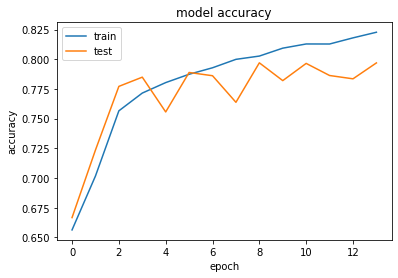

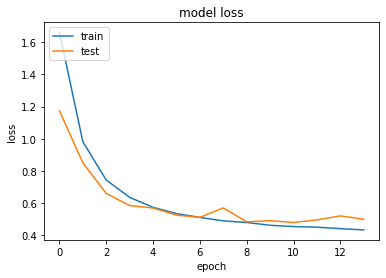

In [20]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
modelPath = '/data/user/mahoque/data_science_project/model/best_model_'+datetime.datetime.now().strftime("%m-%d-%Y-%I-%M")+'.h5'
weightPath = '/data/user/mahoque/data_science_project/model/best_model_weight'+datetime.datetime.now().strftime("%m-%d-%Y-%I-%M")+'.hdf5'
model.save(modelPath)
model.save_weights(weightPath)

In [22]:
print("modelPath: ", modelPath)
print("weightPath: ", weightPath)

modelPath:  /data/user/mahoque/data_science_project/model/best_model_04-26-2020-03-06.h5
weightPath:  /data/user/mahoque/data_science_project/model/best_model_weight04-26-2020-03-06.hdf5


In [23]:
model.load_weights(weightPath)
#model.load_weights(/data/user/mahoque/deep_learning_project/xray-best-model/best_model/best_model_)

In [24]:
print("Total number of test examples: ", X_te.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (3534, 100)
Total number of labels: (3534, 3)


In [25]:
batch_size = 128
test_loss, test_score = model.evaluate(X_te, test_labels, batch_size=batch_size)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

In [26]:
# Get predictions
preds = model.predict(X_te, batch_size=batch_size)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

<Figure size 432x288 with 0 Axes>

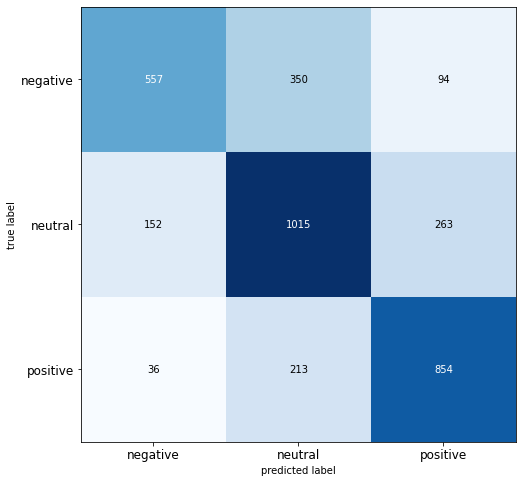

In [27]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), list_classes, fontsize=12)
plt.yticks(range(3), list_classes, fontsize=12)
#plt.savefigure
plt.show()

In [28]:
seq_crawled_tweet = tokenizer.texts_to_sequences(crawled_tweets)

seq_crawled_tweet = pad_sequences(seq_crawled_tweet, maxlen=maxlen)

In [29]:

positive_tweets = []
negative_tweets = []
neutral_tweets = []
positive_counter = 0
negative_counter = 0
neutral_counter = 0

# Get predictions
predictions = model.predict(seq_crawled_tweet, batch_size=batch_size)
for n, prediction in enumerate(predictions):
    pred = predictions.argmax(axis=-1)[n]
    #print(crawled_tweet[n],"\nPrediction:",list_classes[pred],"\n")
    if list_classes[pred] == "positive":
        positive_counter = positive_counter+1
        positive_tweets.append(crawled_tweets[n])
    elif list_classes[pred] == "negative":
        negative_counter = negative_counter+1
        negative_tweets.append(crawled_tweets[n])
    elif list_classes[pred] == "neutral":
        neutral_counter = neutral_counter+1
        neutral_tweets.append(crawled_tweets[n])

print(positive_counter)
print(negative_counter)
print(neutral_counter)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

[('love', 2434), ('great', 1542), ('hope', 1507), ('day', 1399), ('good', 991), ('time', 852), ('thank', 668), ('get', 658), ('kevin', 577), ('happy', 520)]
[('coronavirus', 1112), ('people', 745), ('like', 687), ('take', 527), ('get', 515), ('trump', 506), ('tom', 496), ('virus', 482), ('fucking', 472), ('going', 439)]


<BarContainer object of 10 artists>

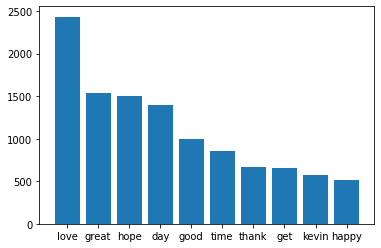

In [31]:
pos = get_top_n_words(positive_tweets, 10)
neg = get_top_n_words(negative_tweets, 10)
print(pos)
print(neg)

dic_pos = dict(pos) 
keys = dic_pos.keys()
values = dic_pos.values()
plt.bar(keys, values)

<BarContainer object of 10 artists>

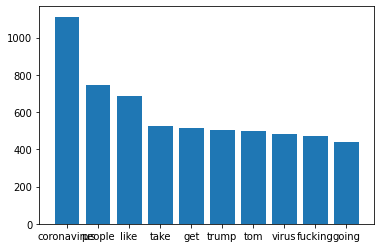

In [32]:
dic_neg = dict(neg) 
keys = dic_neg.keys()
values = dic_neg.values()
plt.bar(keys, values)

In [33]:
def to_percents(data):
    total = float(sum(v for _, v in data))
    data[:] = [(k, v / total) for k, v in data]
    return data

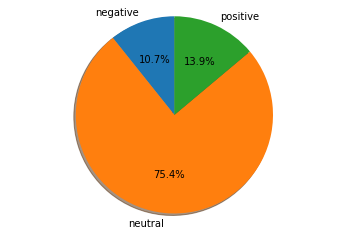

In [34]:
labels = list_classes
sizes = [negative_counter, neutral_counter, positive_counter]
explode = (0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()